In [1]:
from flows import NVPFlow, DFlow, ResFlow, BNFlow, phase
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(1234)

X = np.random.normal(size=[10,3])
X[:,0] = (X[:,0] + X[:,1])/2
X[:,2] = (- X[:,0] - X[:,1] + X[:,2])/3
ystd = 0.5
y = 2*X[:,0] + X[:,1] + 0.5*X[:,2] + 3 + np.random.normal(size=10)*ystd

In [3]:
dim = 2
conf = [[NVPFlow(dim, 'nvp{}'.format(i)),
        ResFlow(dim, 'res{}'.format(i))] for i in range(4)]
appr1 = DFlow(sum(conf, []))

dim = 2
conf = [[NVPFlow(dim, 'nvp2{}'.format(i), aux_vars=appr1.output),
        ResFlow(dim, 'res2{}'.format(i), aux_vars=appr1.output)] for i in range(4)]
appr2 = DFlow(sum(conf, []))

In [4]:
coefs1 = appr1.output[0]
coefs2 = appr2.output[0]
coefs = tf.concat([coefs1, coefs2], axis=0)

logl = -tf.square(y - X[:,0]*coefs[0] - X[:,1]*coefs[1] - X[:,2]*coefs[2] - coefs[3])/(2*ystd**2)
logl = tf.reduce_sum(logl)

In [5]:
def lN(x):
    std = 10.
    s2 = std**2
    tmp = -tf.square(x)/(2*s2) - 0.5*np.log(2*np.pi*s2)
    return tf.reduce_sum(tmp)

In [6]:
gain = logl + lN(coefs1) + lN(coefs2) - appr1.logdens - appr2.logdens

In [7]:
gain

<tf.Tensor 'sub_11:0' shape=(1,) dtype=float64>

In [8]:
opt = tf.train.AdamOptimizer().minimize(-gain)

In [9]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [10]:
for _ in range(10):
    for _ in range(5000):
        v, _ = sess.run([gain, opt],{phase: True})
    print(v[0])

-16.283103623863195
-15.967898752443983
-16.319596464370193
-16.16104190332098
-16.287574866048125
-16.341015142543117
-16.793178654998147
-16.259276735132396
-16.242027317653292
-16.37338227362156


In [11]:
samples = []
for _ in range(3000):
    samples.append(coefs.eval({phase: False}))
samples = np.array(samples)

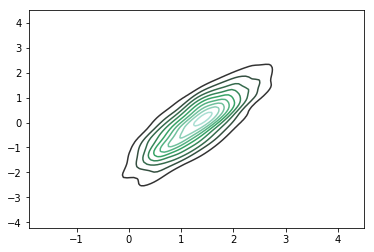

In [12]:
sns.kdeplot(samples[:,0], samples[:,2])
plt.show()

In [13]:
samples.mean(axis=0)

array([ 1.29188698,  0.96084353, -0.03294836,  3.30969167])